In [1]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.densenet import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\Train\\benign',224))
malign_train = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\Train\\malignant',224))
benign_test = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\validation\\benign',224))
malign_test = np.array(Dataset_loader('C:\\Users\\pauls\\Desktop\\Dataset_tumor\\validation\\malignant',224))

100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 174.37it/s]


In [3]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

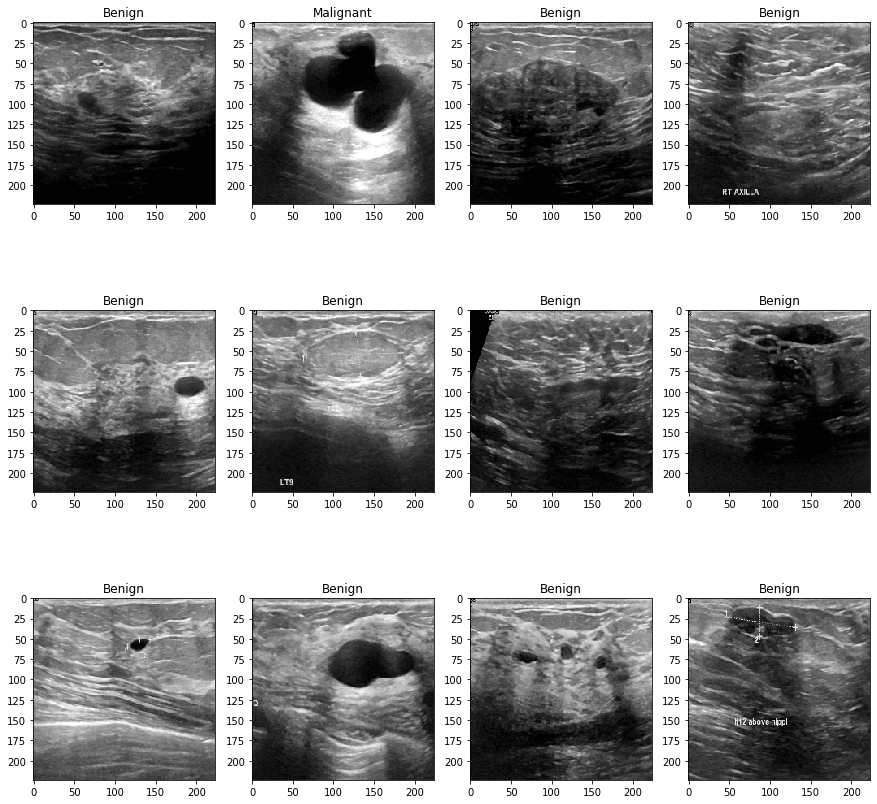

In [4]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [5]:
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [6]:
from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions

In [7]:
IMAGE_SIZE = [224, 224]
densenet = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [8]:
for layer in densenet.layers:
  layer.trainable = False

In [9]:
from glob import glob
folders = glob('C:/Users/pauls/Desktop/Dataset_tumor/Train/*')
print(len(folders))

2


In [10]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

y = Flatten()(densenet.output)
prediction = Dense(len(folders), activation='softmax')(y)
model = Model(inputs=densenet.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

conv3_block12_2_conv (Conv2D)   (None, 28, 28, 32)   36864       conv3_block12_1_relu[0][0]       
__________________________________________________________________________________________________
conv3_block12_concat (Concatena (None, 28, 28, 512)  0           conv3_block11_concat[0][0]       
                                                                 conv3_block12_2_conv[0][0]       
__________________________________________________________________________________________________
pool3_bn (BatchNormalization)   (None, 28, 28, 512)  2048        conv3_block12_concat[0][0]       
__________________________________________________________________________________________________
pool3_relu (Activation)         (None, 28, 28, 512)  0           pool3_bn[0][0]                   
__________________________________________________________________________________________________
pool3_conv (Conv2D)             (None, 28, 28, 256)  131072      pool3_relu[0][0]                 
__________

In [11]:
from tensorflow.keras.optimizers import Adam


adam = Adam()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
model_history = model.fit(x_train, y_train,
          batch_size=10,
          epochs=10,
          verbose=1,
          validation_data=(x_val,y_val))

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpnyrevmhl.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpnyrevmhl.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
46/46 [==============================] - 87s 1s/step - loss: 4.9656 - accuracy: 0.6479 - val_loss: 3.3025 - val_accuracy: 0.7807
Epoch 2/10
46/46 [==============================] - 41s 903ms/step - loss: 0.7704 - accuracy: 0.8897 - val_loss: 2.8169 - val_accuracy: 0.7193
Epoch 3/10
46/46 [==============================] - 41s 889ms/step - loss: 0.5129 - accuracy: 0.9385 - val_loss: 

In [16]:
Y_pred = model.predict(X_test, steps=1,verbose =2)

1/1 - 5s


Confusion matrix, without normalization
[[48  6]
 [ 2 22]]


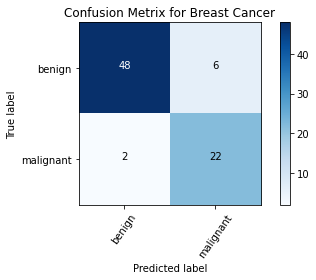

In [17]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

<AxesSubplot:>

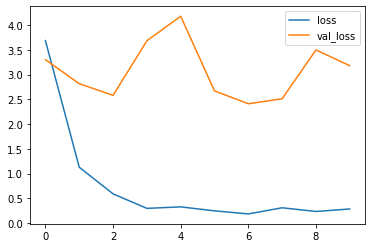

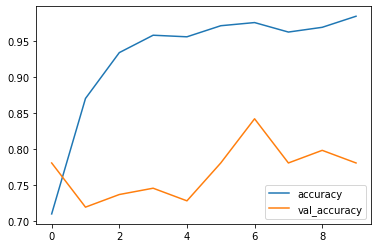

In [18]:
history_df = pd.DataFrame(model_history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(model_history.history)
history_df[['accuracy', 'val_accuracy']].plot()